C:\Users\endal\AppData\Local\Temp\ipykernel_36256\68589869.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=15)
C:\Users\endal\AppData\Local\Temp\ipykernel_36256\68589869.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=15)
C:\Users\endal\AppData\Local\Temp\ipykernel_36256\68589869.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xticklabels(labels, fontsize=15)
C:\Users\endal\AppData\Local\Temp\ipykernel_36256\68589869.py:158: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=15)
C:\Users\endal\AppData\Local\Temp\ipykernel_36256\68589869.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_bar.set_xtickla

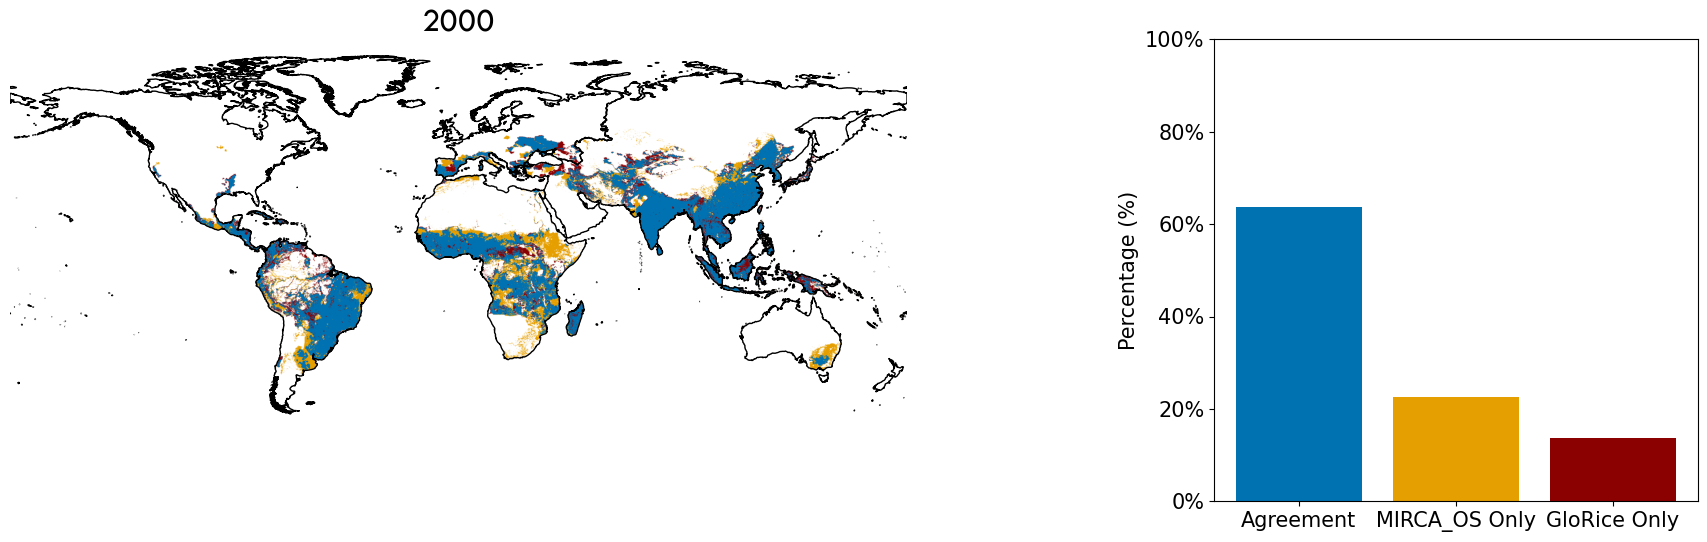

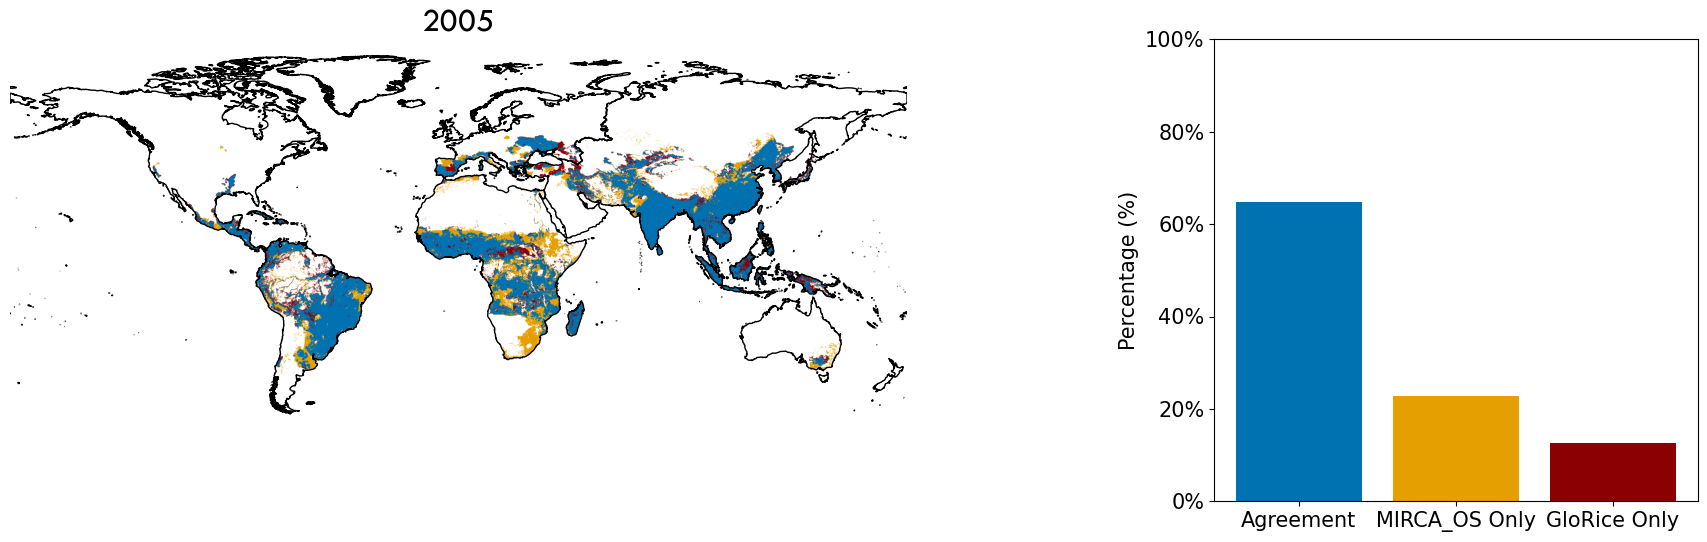

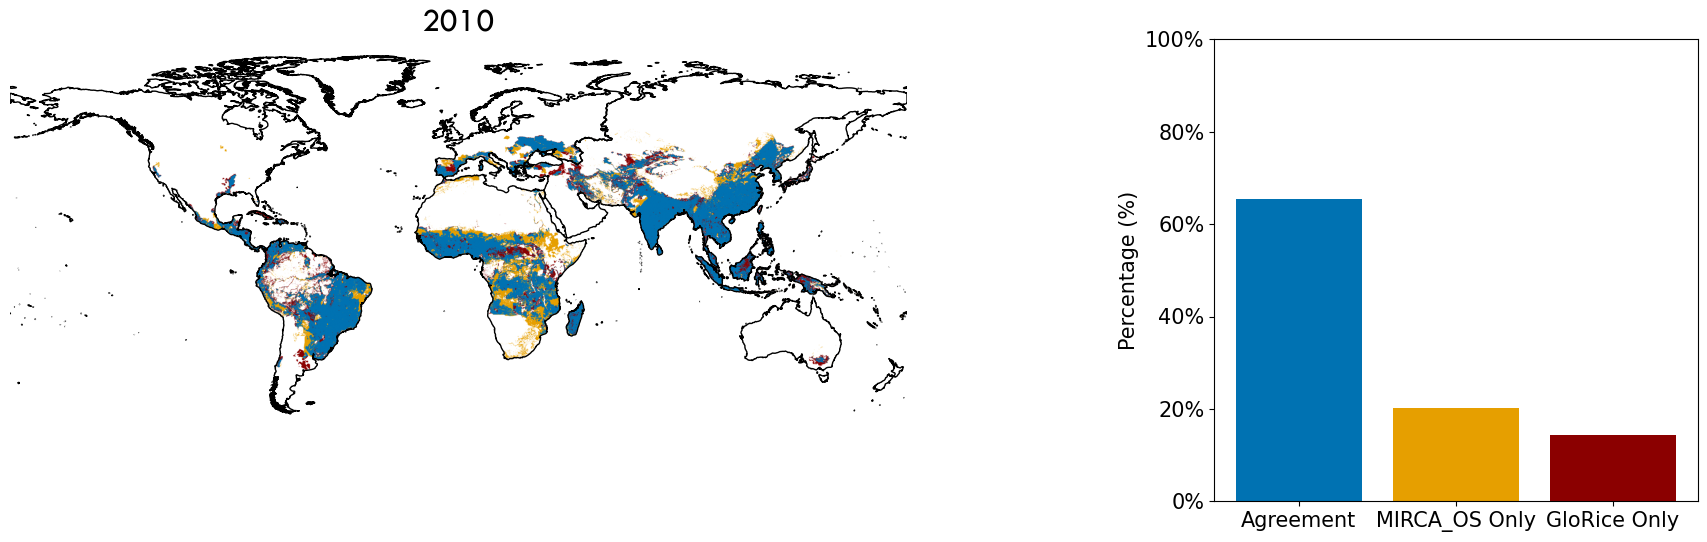

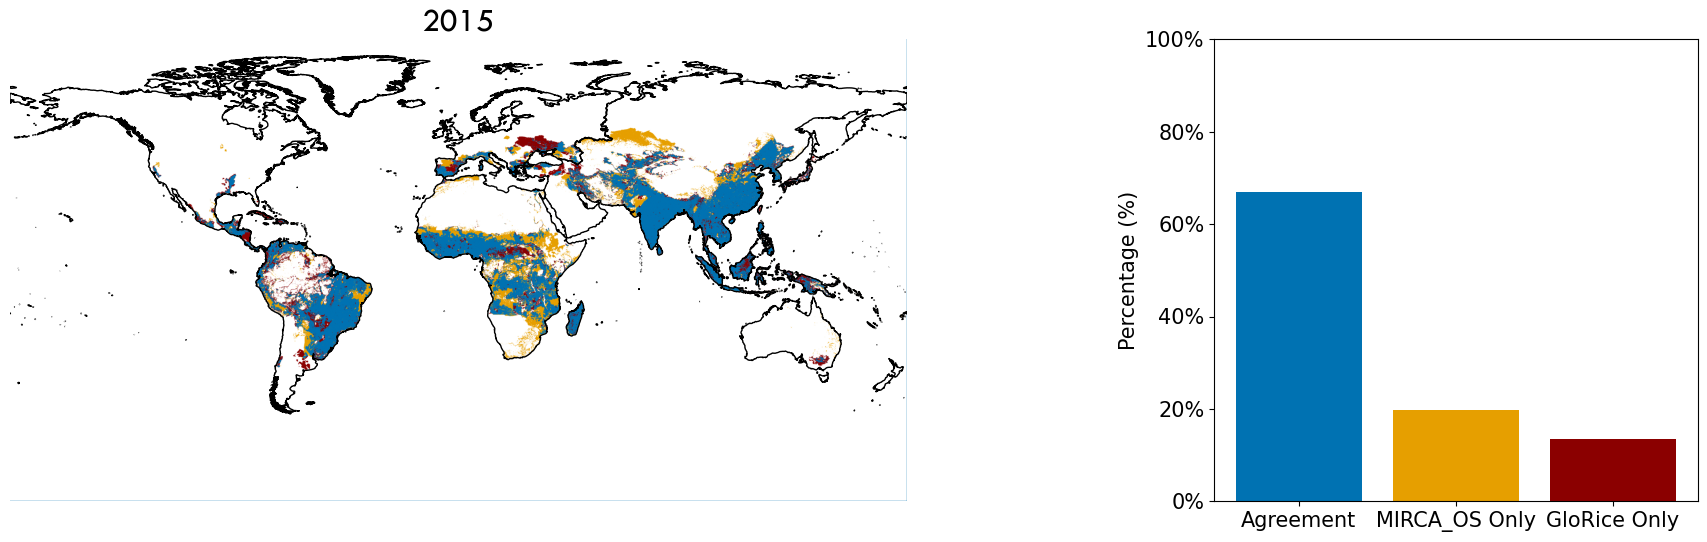

In [6]:
import os
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib import font_manager
from rasterio.warp import reproject, Resampling

# Define colorblind-friendly colors for the plot
dark_blue = '#0072B2'  # Dark Blue for agreement
orange = '#E69F00'  # Orange for MIRCA-OS Only
dark_red = '#8B0000'  # Dark Red for MIRCA2000 Only

# Check if 'Tw Cen MT' font is available
if 'Tw Cen MT' not in [f.name for f in font_manager.fontManager.ttflist]:
    print('The "Tw Cen MT" font is not available on your system. Please use an available font or install "Tw Cen MT".')
    title_font = 'sans-serif'
else:
    title_font = 'Tw Cen MT'

# Function to read raster data
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        return src.read(1), src.transform, src.crs

# Function to reproject and resample raster data to match another raster
def reproject_and_resample(src_data, src_transform, src_crs, dst_shape, dst_transform, dst_crs):
    dst_data = np.zeros(dst_shape, dtype=src_data.dtype)
    reproject(
        source=src_data,
        destination=dst_data,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )
    return dst_data, dst_transform

# Function to get the extent of a raster from its transform
def get_extent(transform, width, height):
    left = transform[2]
    top = transform[5]
    right = left + transform[0] * width
    bottom = top + transform[4] * height
    return (left, right, bottom, top)

# Function to clean raster data
def clean_raster_data(raster_data, extreme_value_threshold=0):
    cleaned_data = np.where(raster_data < extreme_value_threshold, np.nan, raster_data)
    return cleaned_data

# Function to calculate agreement percentages for the bar chart
def calculate_percentages(agree, mirca_os_only, mirca_2000_only):
    agree_count = np.sum(agree)
    mirca_os_only_count = np.sum(mirca_os_only)
    mirca_2000_only_count = np.sum(mirca_2000_only)
    total_valid_pixels = agree_count + mirca_os_only_count + mirca_2000_only_count
    agree_pct = (agree_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_os_only_pct = (mirca_os_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    mirca_2000_only_pct = (mirca_2000_only_count / total_valid_pixels) * 100 if total_valid_pixels > 0 else 0
    return agree_pct, mirca_os_only_pct, mirca_2000_only_pct

# Function to calculate IoU
def calculate_iou(agree, mirca_os_only, mirca_2000_only):
    intersection = np.sum(agree)
    union = intersection + np.sum(mirca_os_only) + np.sum(mirca_2000_only)
    iou = intersection / union if union > 0 else 0
    return iou

# Load the shapefile and reproject it to WGS84
shapefile_path = "E:\\Global Shapefiles\\COntinents onlt\\World_Continents.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs(epsg=4326)

# Directories for raster data
base_dir_os = "E:\\India Validation\\Irrigated area\\New Crop Specific map\\MIRCA-OS"
base_dir_2000 = "E:\\India Validation\\Irrigated area\\New Crop Specific map\\GloRice"

# Crop names
crops = ["2000", "2005", "2010", "2015"]

# Set up the plot dimensions and resolution
figsize = (20, 6)  # Adjusted to include space for the bar chart
dpi = 100  # Adjust the dpi to your preference for resolution

# Create a plot for each crop
for i, crop in enumerate(crops):
    fig, (ax_map, ax_bar) = plt.subplots(1, 2, figsize=figsize, dpi=dpi, gridspec_kw={'width_ratios': [3, 1]})
    
    # Read rasters
    raster1, transform1, crs1 = read_raster(f'{base_dir_os}/{crop}.tif')
    raster2, transform2, crs2 = read_raster(f'{base_dir_2000}/{crop}.tif')

    # Reproject rasters to WGS84
    if crs1 != 'EPSG:4326':
        raster1, transform1 = reproject_and_resample(raster1, transform1, crs1, raster1.shape, transform1, 'EPSG:4326')
    if crs2 != 'EPSG:4326':
        raster2, transform2 = reproject_and_resample(raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326')

    # Ensure raster2 has the same dimensions as raster1
    raster2_resampled, _ = reproject_and_resample(
        raster2, transform2, crs2, raster1.shape, transform1, 'EPSG:4326'
    )

    # Clean rasters
    raster1 = clean_raster_data(raster1)
    raster2_resampled = clean_raster_data(raster2_resampled)
    raster1 = np.maximum(raster1, 0)
    raster2_resampled = np.maximum(raster2_resampled, 0)
    
    # Compare rasters
    agree = (raster1 >= 0) & (raster2_resampled >= 0)
    mirca_os_only = (raster1 > 0) & ((raster2_resampled == 0) | np.isnan(raster2_resampled))
    mirca_2000_only = (raster2_resampled > 0) & ((raster1 == 0) | np.isnan(raster1))

    # Initialize combined RGB array with white background
    combined_rgb = np.ones((raster1.shape[0], raster1.shape[1], 3))

    # Apply new colors based on the comparison
    combined_rgb[agree] = np.array([0, 114, 178]) / 255  # Dark Blue for agreement
    combined_rgb[mirca_os_only] = np.array([230, 159, 0]) / 255  # Orange for MIRCA-OS Only
    combined_rgb[mirca_2000_only] = np.array([139, 0, 0]) / 255  # Dark Red for MIRCA2000 Only

    # Plot map
    extent = get_extent(transform1, raster1.shape[1], raster1.shape[0])
    ax_map.imshow(combined_rgb, extent=extent)
    ax_map.set_title(f'{crop}', fontsize=24, fontname=title_font)
    ax_map.set_frame_on(False)
    world.boundary.plot(ax=ax_map, linewidth=1, edgecolor='black')

    # Remove x and y ticks
    ax_map.set_xticks([])
    ax_map.set_yticks([])

    # Calculate percentages for the bar chart
    agree_pct, mirca_os_only_pct, mirca_2000_only_pct = calculate_percentages(agree, mirca_os_only, mirca_2000_only)

    # Calculate IoU score
    iou = calculate_iou(agree, mirca_os_only, mirca_2000_only)

    # Plot bar chart on ax_bar
#     Plot bar chart on ax_bar
#     labels = ['Agreement', 'MIRCA_OS Only', 'GloRice Only']
#     percentages = [agree_pct, mirca_os_only_pct, mirca_2000_only_pct]
#     ax_bar.bar(labels, percentages, color=[dark_blue, orange, dark_red])
#     ax_bar.set_ylabel('Percentage (%)', fontsize=16)
#     ax_bar.set_ylim(0, 100)
#     ax_bar.set_xticklabels(labels, fontsize=16, rotation=45)  # Rotate labels by 45 degrees
#     ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=16)
    labels = ['Agreement', 'MIRCA_OS Only', 'GloRice Only']
    percentages = [agree_pct, mirca_os_only_pct, mirca_2000_only_pct]
    ax_bar.bar(labels, percentages, color=[dark_blue, orange, dark_red])
    ax_bar.set_ylabel('Percentage (%)', fontsize=15)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_xticklabels(labels, fontsize=15)
    ax_bar.set_yticklabels([f'{int(tick)}%' for tick in ax_bar.get_yticks()], fontsize=15)

#     # Display IoU score on the bar chart
#     ax_bar.text(1.5, 105, f'IoU: {iou:.2f}', ha='center', va='center', fontsize=20, fontname=title_font, bbox=dict(facecolor='white', edgecolor='none', pad=2.0))

#     # Legend
#     if i == len(crops) - 1:
#         legend_elements = [
#             mpatches.Patch(color=dark_blue, label='Agreement'),
#             mpatches.Patch(color=orange, label='MIRCA-OS Only'),
#             mpatches.Patch(color=dark_red, label='GloRice Only')
#         ]
#         plt.figlegend(handles=legend_elements, loc='lower center', ncol=3, fontsize=15, frameon=False, bbox_to_anchor=(0.5, -0.05))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the rect parameter to fit your plot and legend inside the figure
    plt.savefig(f'E:\\India Validation\\Irrigated area\\New Crop Specific map\\Maps\\{crop}.png', bbox_inches='tight')

plt.show()


Crop: 2000, Number of valid data points: 144409
Crop: 2005, Number of valid data points: 163796
Crop: 2010, Number of valid data points: 163049
Crop: 2015, Number of valid data points: 163796


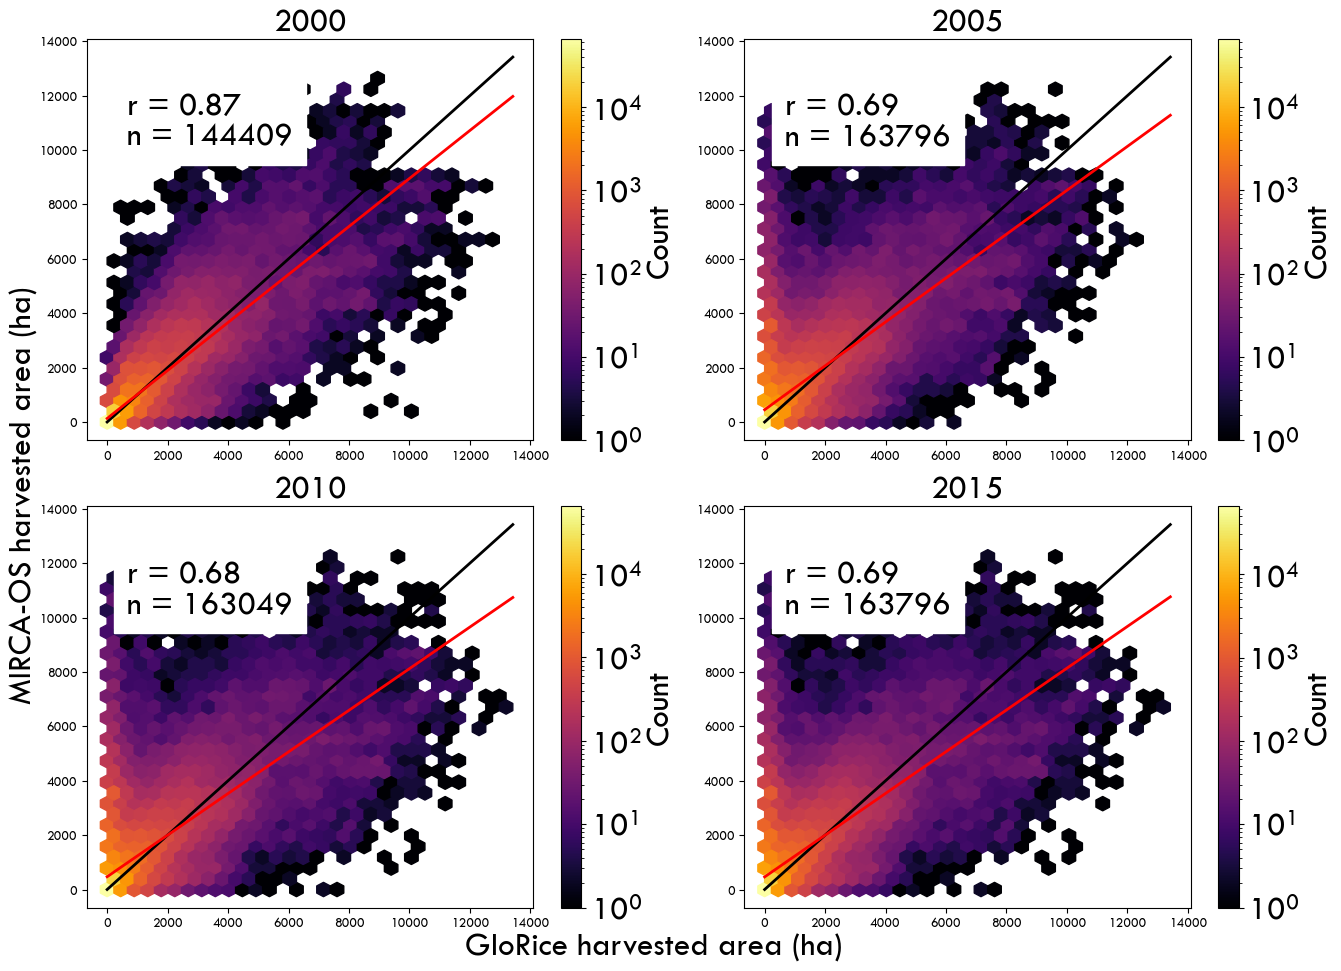

Crop: 2000, Number of valid data points: 407638
Crop: 2005, Number of valid data points: 415093
Crop: 2010, Number of valid data points: 406748
Crop: 2015, Number of valid data points: 481179


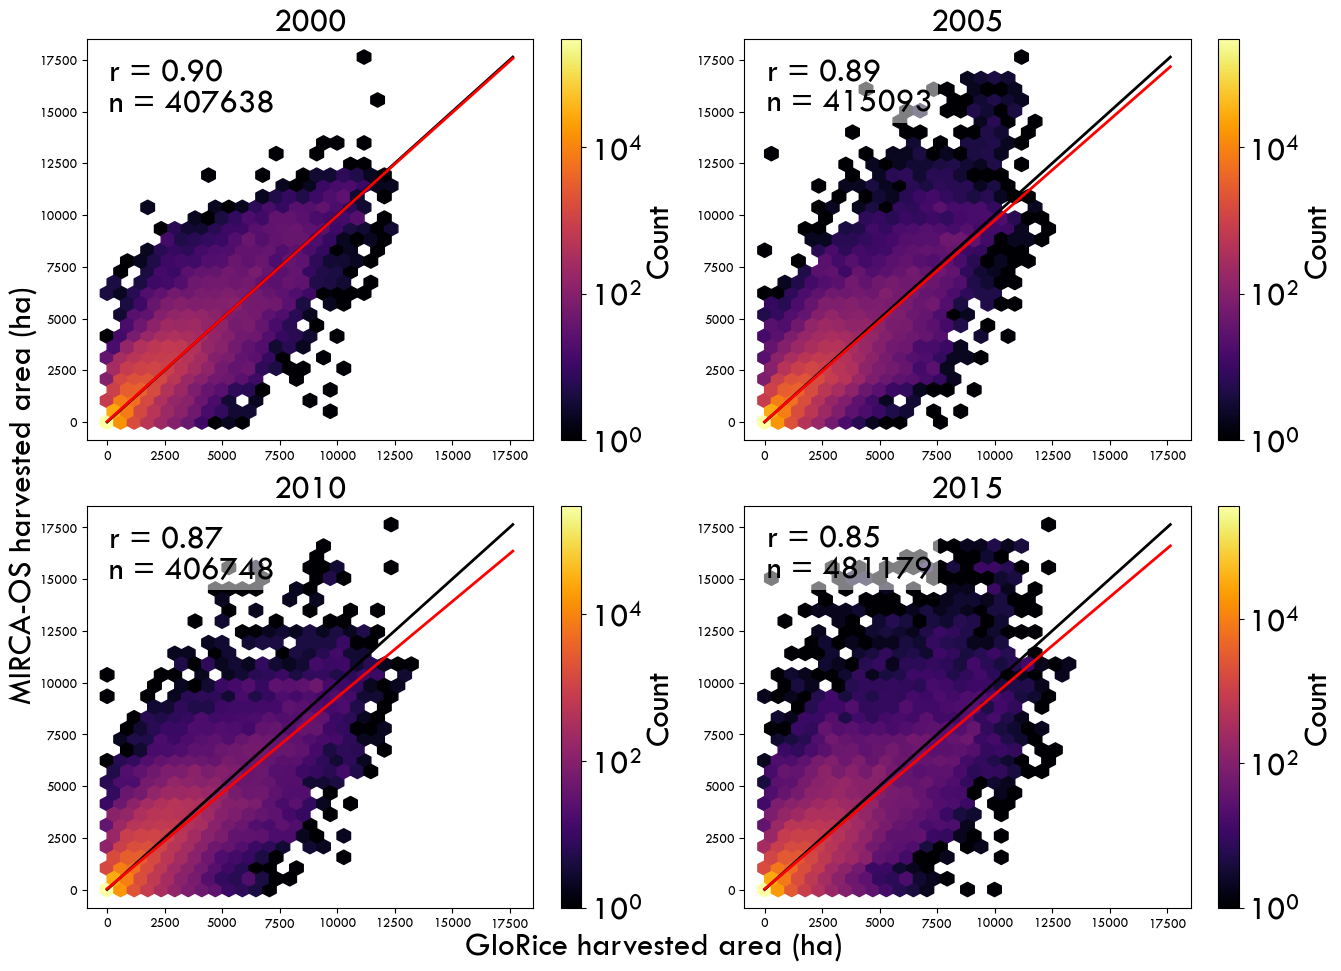

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from scipy.stats import linregress, pearsonr

# Set the font family globally for all plots
plt.rcParams['font.family'] = 'Tw Cen MT'

# Define the base font size
font_size = 24

# Define the clean_raster_data function
def clean_raster_data(raster_data, nan_value):
    """
    Replace the given NaN value in raster data with actual NaNs and zero for negative values.
    """
    raster_data = np.where(raster_data == nan_value, np.nan, raster_data)
    return np.where((raster_data < 0), np.nan, raster_data)

# Define the plot_scatter_and_regression function
def plot_scatter_and_regression(ax, x, y, crop_name, n_valid, common_min, common_max):
    # Calculate the Pearson correlation coefficient
    r, _ = pearsonr(x, y)

    # Create a hexbin plot 
    hb = ax.hexbin(x, y, gridsize=30, cmap='inferno', bins='log', extent=(common_min, common_max, common_min, common_max))
    cbar = ax.figure.colorbar(hb, ax=ax, label='Count')
    cbar.ax.tick_params(labelsize=font_size)  # Set the fontsize for colorbar ticks
    cbar.set_label('Count', size=font_size)  # Set the fontsize for colorbar label

    # Add the 1:1 line
    ax.plot([common_min, common_max], [common_min, common_max], color='black', linestyle='-', linewidth=2)

    # Perform linear regression
    slope, intercept = linregress(x, y)[:2]
    ax.plot([common_min, common_max], [intercept + slope * common_min, intercept + slope * common_max], color='red', linewidth=2)

    # Add text annotation in the plot (upper left corner, transparent background)
    text_x = 0.05
    text_y = 0.95
    ax.text(text_x, text_y, f'r = {r:.2f}\nn = {n_valid}', transform=ax.transAxes, color='black', ha='left', va='top', fontsize=font_size, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Set title
    ax.set_title(f'{crop_name}', fontsize=font_size)

# Define the paths to the directories
folder1 = "E:\\India Validation\\Irrigated area\\New Crop Specific map\\GloRice"
folder2 = "E:\\India Validation\\Irrigated area\\New Crop Specific map\\MIRCA-OS"
# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.ravel()

# List the raster files
rasters1 = {os.path.splitext(file)[0]: os.path.join(folder1, file) for file in os.listdir(folder1) if file.endswith('.tif')}
rasters2 = {os.path.splitext(file)[0]: os.path.join(folder2, file) for file in os.listdir(folder2) if file.endswith('.tif')}

# Define the NaN value
nan_value = -3.40282306074e+38

# Determine the maximum dimensions for resampling
max_height = 0
max_width = 0
for raster_path in list(rasters1.values()) + list(rasters2.values()):
    with rasterio.open(raster_path) as src:
        max_height = max(max_height, src.height)
        max_width = max(max_width, src.width)

# Initialize variables to find the common min and max values
common_min_x = float('inf')
common_max_x = float('-inf')
common_min_y = float('inf')
common_max_y = float('-inf')

# Function to resample raster to match the maximum dimensions
def resample_raster(src, max_height, max_width):
    data = src.read(
        out_shape=(
            src.count,
            max_height,
            max_width
        ),
        resampling=Resampling.bilinear
    )
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    return data[0], transform

# Iterate over the rasters to determine the common axis limits
for crop_name, raster_path1 in rasters1.items():
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Resample the rasters to the maximum dimensions
            data1, _ = resample_raster(src1, max_height, max_width)
            data2, _ = resample_raster(src2, max_height, max_width)
            
            # Clean the data
            data1 = clean_raster_data(data1, nan_value)
            data2 = clean_raster_data(data2, nan_value)

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2 = data2.flatten()

            # Filter out invalid data points
            valid_mask = (data1 >= 0) & (data2 >= 0)
            data1 = data1[valid_mask]
            data2 = data2[valid_mask]

            # Remove NaN values from both datasets
            mask = ~np.isnan(data1) & ~np.isnan(data2)
            data1 = data1[mask]
            data2 = data2[mask]

            # Update common min and max values
            common_min_x = min(common_min_x, np.nanmin(data1))
            common_max_x = max(common_max_x, np.nanmax(data1))
            common_min_y = min(common_min_y, np.nanmin(data2))
            common_max_y = max(common_max_y, np.nanmax(data2))

common_min = min(common_min_x, common_min_y)
common_max = max(common_max_x, common_max_y)

# Iterate over the rasters again to plot the data
for crop_name, raster_path1 in rasters1.items():
    raster_path2 = rasters2.get(crop_name)
    if raster_path2:
        with rasterio.open(raster_path1) as src1, rasterio.open(raster_path2) as src2:
            # Resample the rasters to the maximum dimensions
            data1, _ = resample_raster(src1, max_height, max_width)
            data2, _ = resample_raster(src2, max_height, max_width)

            # Clean the data
            data1 = clean_raster_data(data1, nan_value)
            data2 = clean_raster_data(data2, nan_value)

            # Flatten the arrays to create a 1D array for each
            data1 = data1.flatten()
            data2 = data2.flatten()

            # Filter out invalid data points
            valid_mask = (data1 >= 0) & (data2 >= 0)
            data1 = data1[valid_mask]
            data2 = data2[valid_mask]

            # Remove NaN values from both datasets
            mask = ~np.isnan(data1) & ~np.isnan(data2)
            data1 = data1[mask]
            data2 = data2[mask]

            # Calculate the number of valid data points for this crop
            n_valid = len(data1)
            print(f'Crop: {crop_name}, Number of valid data points: {n_valid}')  # Debugging statement

            # Find the next available subplot
            ax = next((ax for ax in axs if not hasattr(ax, 'data_plotted')), None)
            if ax is None:
                print("No more empty subplots available.")
                break

            # Plot the data on the corresponding subplot axis
            plot_scatter_and_regression(ax, data1, data2, crop_name, n_valid, common_min, common_max)
            
            # Mark this axis as having data plotted on it
            ax.data_plotted = True

# Set common x and y labels
fig.text(0.5, 0.04, 'GloRice harvested area (ha)', ha='center', fontsize=font_size)
fig.text(0.04, 0.5, 'MIRCA-OS harvested area (ha)', va='center', rotation='vertical', fontsize=font_size)

# Adjust the layout and display the plot
plt.tight_layout(rect=[0.05, 0.05, 1, 1])  # Adjust rect to fit common labels
plt.savefig('E:\\India Validation\\Irrigated area\\New Crop Specific map\\Maps\\Sctter.png', bbox_inches='tight') 
plt.show()
